<a href="https://colab.research.google.com/github/Sujal-py3/AI-Native-Recommender-System/blob/main/Multi_DeepSORT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🧠 Task 2: Real-Time Stream Simulation & Event Trigger

In this task, I simulated a real-time video stream using OpenCV and applied YOLOv8 for object detection. The objective was to trigger an alert when **3 or more people** appeared in **5 consecutive frames**, simulating a "crowd detected" scenario.

---

#### 🔧 Approach

- Processed every **3rd frame** to mimic real-time stream constraints.
- Used **YOLOv8n** for fast and efficient person detection.
- Maintained a **sliding window of 5 frames** to monitor people count.
- Triggered and logged an alert when crowd conditions were met.
- Stored alerts in a structured `alert_log.json` file.
- Plotted a **timeline of alert occurrences** using `matplotlib`.
- Saved and displayed **sample detection frames** with bounding boxes.

---

This setup allows for basic real-time monitoring and alerting based on visual crowd activity.


In [ ]:
# Install YOLOv8
!pip install ultralytics --quiet

# Imports
import cv2
import json
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab import files
import os
import datetime
import numpy as np
from IPython.display import clear_output

# Created output directory
os.makedirs("output_frames", exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyt

In [ ]:
#Upload the video file
uploaded = files.upload()

video_path = next(iter(uploaded))  # Get the filename
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise Exception("Error loading video file!")

print("Video loaded successfully 🎥")


Saving 15sec_input_720p.mp4 to 15sec_input_720p (1).mp4
Video loaded successfully 🎥


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import json

# I'm using the YOLOv8n model because it's lightweight and good for fast inference
model = YOLO("yolov8n.pt")

# Initializing everything I need to track the detection state
frame_count = 0
consecutive_frames = []   # Stores people count for the last 5 frames
alerts = []               # Helps avoid duplicate alerts
alert_log = []            # Stores final alert messages
frame_timestamps = []     # Stores the timestamp of every processed frame

# Also saving a few sample frames to show detection results later
sample_frames = []
sample_timestamps = []

# Loading the video I want to process (replace the path if needed)
video_path = "15sec_input_720p.mp4"  # 🔁 Replace with your actual video path
cap = cv2.VideoCapture(video_path)

# Going through the video frame by frame
while True:
    ret, frame = cap.read()
    if not ret:
        break  # No more frames to read

    frame_count += 1

    # Getting timestamp at the very beginning (before any conditions)
    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
    frame_timestamps.append(timestamp)

    # I’m only running detection on every 3rd frame to simulate streaming + reduce compute
    if frame_count % 3 != 0:
        continue

    # Performing object detection
    results = model(frame, verbose=False)[0]
    people_count = 0

    # Saving up to 6 sample detection frames with bounding boxes (for visuals)
    if len(sample_frames) < 6:
        # Converting frame to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)

        # Drawing bounding boxes for detected people only (class 0)
        for box in results.boxes:
            cls_id = int(box.cls[0])
            if cls_id == 0:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])
                label = f"Person {conf:.2f}"
                cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame_rgb, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Saving the frame and the timestamp for plotting later
        sample_frames.append(frame_rgb)
        sample_timestamps.append(f"{timestamp:.2f}s")

    # Counting how many people are in the current frame
    for box in results.boxes:
        cls_id = int(box.cls[0])
        if cls_id == 0:  # Only counting 'person' class
            people_count += 1

    # Storing the count in my sliding window list
    consecutive_frames.append(people_count)

    # Only keeping the last 5 frames in the window
    if len(consecutive_frames) > 5:
        consecutive_frames.pop(0)

    # Here’s my alert condition:
    # 5 consecutive frames with 3 or more people → trigger a crowd alert
    if len(consecutive_frames) == 5 and all(count >= 3 for count in consecutive_frames):
        alert_msg = {
            "timestamp": f"{timestamp:.2f}s",
            "message": "⚠️ Crowd Detected"
        }

        # I only log a new alert if it’s been at least 2 seconds since the last one
        if not alerts or timestamp - alerts[-1]['timestamp'] > 2:
            alerts.append({"timestamp": timestamp, "count": people_count})
            alert_log.append(alert_msg)
            print(alert_msg)

# All done with the video
cap.release()






{'timestamp': '0.56s', 'message': '⚠️ Crowd Detected'}
{'timestamp': '2.60s', 'message': '⚠️ Crowd Detected'}
{'timestamp': '4.64s', 'message': '⚠️ Crowd Detected'}
{'timestamp': '6.68s', 'message': '⚠️ Crowd Detected'}
{'timestamp': '8.72s', 'message': '⚠️ Crowd Detected'}
{'timestamp': '10.76s', 'message': '⚠️ Crowd Detected'}
{'timestamp': '12.80s', 'message': '⚠️ Crowd Detected'}
{'timestamp': '14.84s', 'message': '⚠️ Crowd Detected'}


In [ ]:
with open("alert_log.json", "w") as f:
    json.dump(alert_log, f, indent=2)

print("✅ Alert log saved as alert_log.json")


✅ Alert log saved as alert_log.json


/tmp/ipython-input-26-1778802363.py:9: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


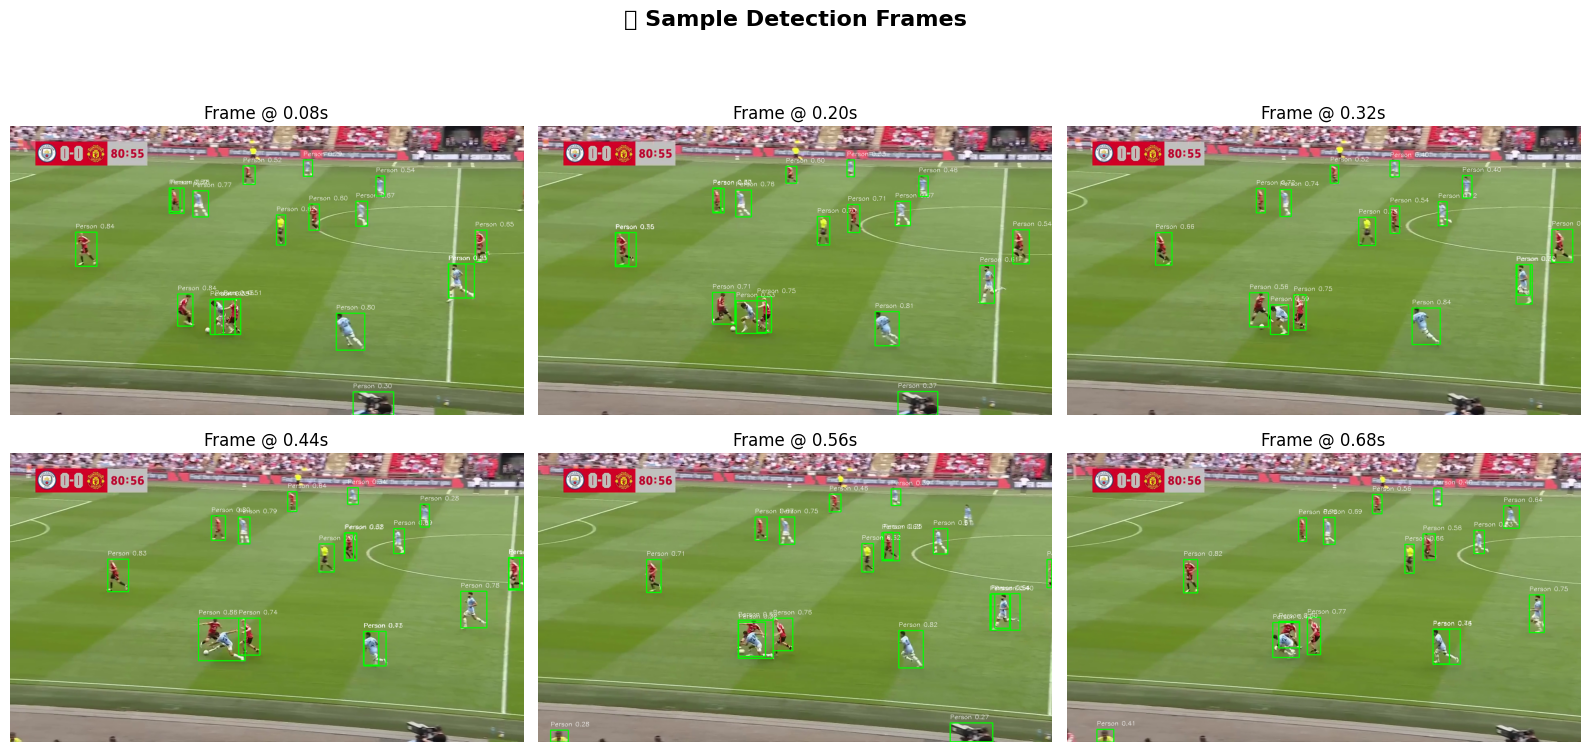

In [ ]:
# Displaying the sample detection frames in a nice grid
plt.figure(figsize=(16, 8))
for i, frame in enumerate(sample_frames):
    plt.subplot(2, 3, i + 1)
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f"Frame @ {sample_timestamps[i]}")
plt.suptitle("🔍 Sample Detection Frames", fontsize=16, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

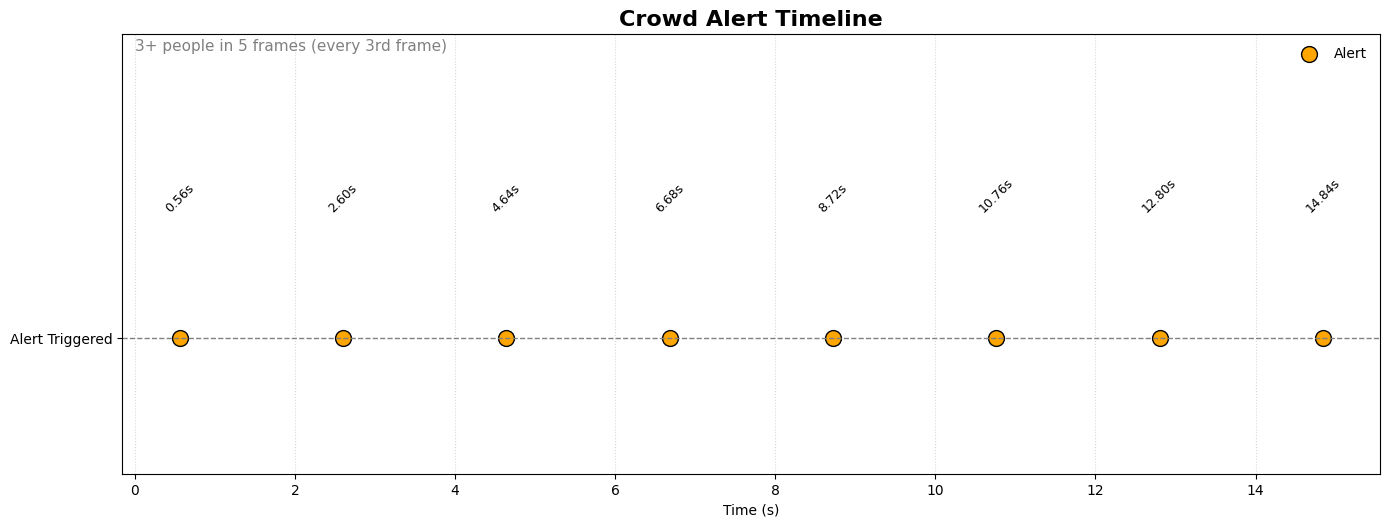

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# I’m marking alerts as orange dots
plt.scatter(alert_secs, [1]*len(alert_secs), color='#FFA500', s=130,
            edgecolors='black', label="Alert")

# Reference line for alert threshold
plt.axhline(1, color='gray', linestyle='--', linewidth=1)

# Adding timestamps above each dot
for x in alert_secs:
    plt.text(x, 1.075, f"{x:.2f}s", ha='center', fontsize=9, rotation=45)

# Title + quick note below
plt.title("Crowd Alert Timeline", fontsize=16, weight='bold')
plt.text(0, 1.17, "3+ people in 5 frames (every 3rd frame)", fontsize=11, color='gray')

# Y-axis is just storytelling
plt.yticks([1], ["Alert Triggered"])
plt.ylim(0.92, 1.18)

plt.xlabel("Time (s)")
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.legend(frameon=False)
plt.tight_layout()
plt.subplots_adjust(top=0.83)

plt.show()
